In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [2]:
PROJ_ROOT = '/Users/mloui/Documents/STAR/SOFAR'

In [3]:
class simpleLSTM(nn.Module):
    def __init__(self, data_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=data_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, data_dim)
    def forward(self, x):
        #print(x.shape)
        x, _ = self.lstm(x)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        #print()
        return x

In [4]:
class lstmDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, index):
        sample = {
            'x': self.x[index].clone().detach().float(),
            'y': self.y[index].clone().detach().float()}
        return sample
    
    def __len__(self):
        return len(self.x)

In [73]:
def create_dataset(dataset, lookback, normalize=True):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    # Normalize each variable
    min_vals = np.amin(dataset, axis=0)
    max_vals = np.amax(dataset, axis=0)
    min_arr = np.repeat(np.expand_dims(min_vals, axis=0), len(dataset), axis=0)
    max_arr = np.repeat(np.expand_dims(max_vals, axis=0), len(dataset), axis=0)
    dataset = (dataset-min_arr)/(max_arr-min_arr)
    
    x, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        x.append(feature)
        y.append(target)
    return x, y, lstmDataset(torch.tensor(np.array(x)), torch.tensor(np.array(y)))

In [10]:
# Load training data
normal_data = pd.read_csv(f'{PROJ_ROOT}/data/simulated/sim_train1.csv')
all_data = normal_data.to_numpy()
print(all_data.shape)
# Remove fault columns
use_data = all_data[:,:-3]
print(use_data.shape)
print(use_data[10])

(540000, 16)
(540000, 13)
[ 4.27489169  1.61377738  3.28712251  7.9413146   0.25554456  0.63067393
  7.96395936  0.26761411  0.20830884 -0.51720671  0.15783271  0.18073429
 10.        ]


In [70]:
# Create training and test sets
lookback = 20
dataset = create_dataset(use_data, lookback)
train, test = data.random_split(dataset, [0.8, 0.2])
x_train = train[:]['x']
y_train = train[:]['y']
#y_train = torch.unsqueeze(train[:]['y'], dim=1)
x_test = test[:]['x']
y_test = test[:]['y']
#y_test = torch.unsqueeze(test[:]['y'], dim=1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([431984, 20, 13])
torch.Size([431984, 20, 13])
torch.Size([107996, 20, 13])
torch.Size([107996, 20, 13])


In [69]:
print(x_train[0,0])
print(y_train[0,0])

print(x_test[0,0])
print(y_test[0,0])

tensor([0.4649, 0.6445, 0.5344, 0.7655, 0.7493, 0.7514, 0.0862, 0.2101, 0.8247,
        0.7240, 0.0268, 0.0176, 0.7694])
tensor([0.2790, 0.4897, 0.1608, 0.0047, 0.3792, 0.5994, 0.7312, 0.5635, 0.0682,
        0.2277, 0.3166, 0.0683, 0.3128])
tensor([0.6599, 0.4966, 0.9616, 0.4049, 0.6708, 0.6898, 0.9798, 0.9079, 0.0077,
        0.2426, 0.5802, 0.0542, 0.1129])
tensor([0.7391, 0.4533, 0.9024, 0.3430, 0.7396, 0.5811, 0.9082, 0.9312, 0.0348,
        0.2452, 0.4605, 0.0378, 0.1129])


In [76]:
x, y, _ = create_dataset(use_data, lookback)

In [85]:
print(x[2][0])
print(y[1][0])

[1.58235878e-01 3.40457354e-01 1.08714688e-01 3.45529712e-01
 2.85364596e-01 9.56358714e-01 8.98947615e-01 4.45973772e-01
 6.03041847e-02 9.86483590e-02 5.48282909e-02 4.67827372e-02
 3.70371056e-06]
[1.58235878e-01 3.40457354e-01 1.08714688e-01 3.45529712e-01
 2.85364596e-01 9.56358714e-01 8.98947615e-01 4.45973772e-01
 6.03041847e-02 9.86483590e-02 5.48282909e-02 4.67827372e-02
 3.70371056e-06]


Things to try: https://www.mathworks.com/matlabcentral/answers/1890272-lstm-high-training-loss-not-decreasing-and-remain-constant

In [46]:
# Train model
batch_size = 128
lr = 1e-6
weight_decay = 1e-4
train_loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=batch_size)
test_loader = data.DataLoader(data.TensorDataset(x_test, y_test), shuffle=True, batch_size=batch_size)
model = simpleLSTM(data_dim=use_data.shape[1])
optimizer = optim.Adam(model.parameters(),  lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
 
n_epochs = 20
bar = tqdm.tqdm(total=n_epochs)
train_loss_list = []
val_loss_list = []
for epoch in range(n_epochs):
    overall_loss = 0
    model.train()
    cnt = 0
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
        cnt += 1
    bar.update()
    epoch_train_loss = overall_loss/cnt
    train_loss_list.append(epoch_train_loss)
    # Validation
    model.eval()
    with torch.no_grad():
        '''
        y_pred = model(x_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(x_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        train_loss.append(train_rmse)
        val_loss.append(test_rmse)
        '''
        epoch_val_loss = 0
        cnt = 0
        for x_test, y_test in test_loader:
            y_pred = model(x_test)
            val_loss = loss_fn(y_pred, y_test)
            epoch_val_loss += val_loss.item()
            cnt += 1
    epoch_val_loss = epoch_val_loss/cnt
    val_loss_list.append(epoch_val_loss)
    #print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, epoch_train_loss, epoch_val_loss))
bar.close()

  5%|██▏                                        | 1/20 [02:46<52:44, 166.56s/it]

Epoch 0: train loss 0.2783, test loss 0.2653


 10%|████▎                                      | 2/20 [05:19<47:34, 158.61s/it]

Epoch 1: train loss 0.2506, test loss 0.2362


 15%|██████▍                                    | 3/20 [07:40<42:42, 150.75s/it]

Epoch 2: train loss 0.2192, test loss 0.2017


 20%|████████▌                                  | 4/20 [10:43<43:35, 163.47s/it]

Epoch 3: train loss 0.1813, test loss 0.1606


 25%|██████████▊                                | 5/20 [13:21<40:18, 161.27s/it]

Epoch 4: train loss 0.1400, test loss 0.1218


 30%|████████████▉                              | 6/20 [15:44<36:12, 155.15s/it]

Epoch 5: train loss 0.1084, test loss 0.0983


 35%|███████████████                            | 7/20 [18:17<33:29, 154.55s/it]

Epoch 6: train loss 0.0909, test loss 0.0848


 40%|█████████████████▏                         | 8/20 [20:47<30:36, 153.03s/it]

Epoch 7: train loss 0.0808, test loss 0.0768


 45%|███████████████████▎                       | 9/20 [23:04<27:06, 147.87s/it]

Epoch 8: train loss 0.0745, test loss 0.0712


 50%|█████████████████████                     | 10/20 [25:35<24:47, 148.79s/it]

Epoch 9: train loss 0.0696, test loss 0.0665


 55%|███████████████████████                   | 11/20 [28:09<22:35, 150.61s/it]

Epoch 10: train loss 0.0652, test loss 0.0622


 60%|█████████████████████████▏                | 12/20 [30:52<20:35, 154.39s/it]

Epoch 11: train loss 0.0610, test loss 0.0581


 65%|███████████████████████████▎              | 13/20 [33:23<17:53, 153.41s/it]

Epoch 12: train loss 0.0568, test loss 0.0540


 70%|█████████████████████████████▍            | 14/20 [36:04<15:33, 155.56s/it]

Epoch 13: train loss 0.0528, test loss 0.0502


 75%|███████████████████████████████▌          | 15/20 [38:52<13:16, 159.36s/it]

Epoch 14: train loss 0.0492, test loss 0.0471


 80%|█████████████████████████████████▌        | 16/20 [41:28<10:33, 158.30s/it]

Epoch 15: train loss 0.0464, test loss 0.0446


 85%|███████████████████████████████████▋      | 17/20 [44:00<07:49, 156.36s/it]

Epoch 16: train loss 0.0441, test loss 0.0424


 90%|█████████████████████████████████████▊    | 18/20 [46:27<05:07, 153.52s/it]

Epoch 17: train loss 0.0420, test loss 0.0404


 95%|███████████████████████████████████████▉  | 19/20 [48:41<02:27, 147.78s/it]

Epoch 18: train loss 0.0399, test loss 0.0384


100%|██████████████████████████████████████████| 20/20 [50:58<00:00, 152.91s/it]

Epoch 19: train loss 0.0380, test loss 0.0365


In [47]:
torch.save(model.state_dict(), f'{PROJ_ROOT}/models/lstm.pt')

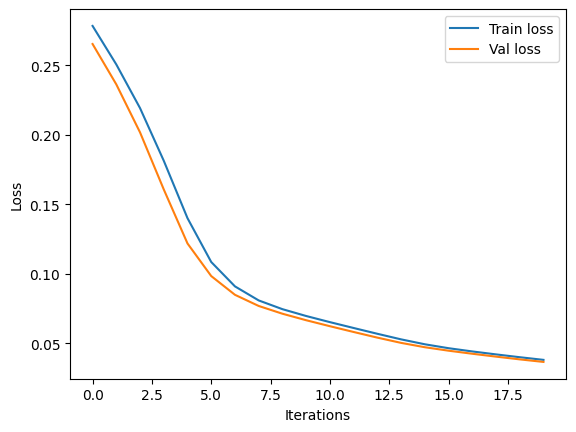

In [49]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Val loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluate

In [62]:
val,_ = data.random_split(dataset, [0.2, 0.8])

x_val = val[:]['x']
y_val = val[:]['y']

print(x_val.shape)
print(y_val.shape)

print(x_val[0,0])
print(y_val[0,0])

torch.Size([107996, 20, 13])
torch.Size([107996, 20, 13])
tensor([0.3088, 0.5682, 0.7921, 0.6106, 0.7367, 0.5799, 0.0808, 0.3153, 0.9132,
        0.5700, 0.0276, 0.0796, 0.5790])
tensor([0.3663, 0.4131, 0.7109, 0.7177, 0.5829, 0.4122, 0.1528, 0.3142, 0.9175,
        0.5521, 0.0457, 0.0600, 0.5790])


In [65]:
lstm_out = model(x_val)

In [66]:
print(lstm_out.shape)

torch.Size([107996, 20, 13])


In [68]:
print(x_val[0,0])
print(y_val[0,0])
print(lstm_out[0,0])

tensor([0.3088, 0.5682, 0.7921, 0.6106, 0.7367, 0.5799, 0.0808, 0.3153, 0.9132,
        0.5700, 0.0276, 0.0796, 0.5790])
tensor([0.3663, 0.4131, 0.7109, 0.7177, 0.5829, 0.4122, 0.1528, 0.3142, 0.9175,
        0.5521, 0.0457, 0.0600, 0.5790])
tensor([0.2769, 0.3266, 0.3440, 0.3045, 0.3533, 0.3307, 0.3424, 0.1371, 0.2916,
        0.3147, 0.0480, 0.0441, 0.2992], grad_fn=<SelectBackward0>)
